In [111]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.chdir('/data/arpit.goel/30_ClaimPrediction')

ins=pd.read_pickle('03.CleanData/ins.pkl')
oos=pd.read_pickle('03.CleanData/oos.pkl')
oot=pd.read_pickle('03.CleanData/oot.pkl')

idv_vars=list(set(ins.columns).intersection(set(oot.columns)))


In [250]:
from sklearn.metrics import roc_curve, auc

def get_roc(df,score,target,title,plot=1):
    df1 = df[[score,target]].dropna()
    fpr, tpr, thresholds = roc_curve(df1[target], df1[score])
    ks=np.abs(tpr-fpr)
    if plot==1:
    # Plot ROC curve
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label='AUC=%0.2f KS=%0.2f' %(auc(fpr, tpr),ks.max()))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.grid(b=True, which='both', color='0.65',linestyle='-')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title+'Receiver Operating Characteristic')
        plt.legend(loc="lower right")
    return auc(fpr, tpr),np.max(np.abs(tpr-fpr)),thresholds[ks.argmax()]


In [251]:
from sklearn.linear_model import LogisticRegression

reg_params={}
for alpha in 10**(np.arange(-10,10,0.5)):
    clf=LogisticRegression(penalty='l1',C=1/alpha)
    clf.fit(ins[idv_vars],ins['target'])
    ins['prediction']=clf.predict_proba(ins[idv_vars])[:,1]
    oos['prediction']=clf.predict_proba(oos[idv_vars])[:,1]
    oot['target']=clf.predict_proba(oot[idv_vars])[:,1]
    reg_params[alpha]=[get_roc(ins,'prediction','target','ROC',0)[0],get_roc(oos,'prediction','target','ROC',0)[0]]
    #var_importance=pd.Series(clf.coef_[0],index=idv_vars).sort_values()
    #oot[['id','target']].to_csv('04.Results/1.LR_1.csv',index=False)

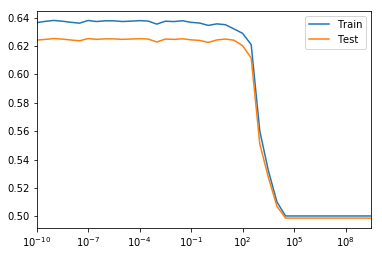

In [252]:
pd.DataFrame(reg_params,index=['Train','Test']).T.plot(logx=True)
plt.show()

In [237]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc

rfc=RandomForestClassifier(n_estimators=1000,max_depth=10,min_samples_leaf=2000,n_jobs=-1)
rfc.fit(ins[idv_vars],ins['target'])
imp_vars=pd.Series(rfc.feature_importances_,index=idv_vars).sort_values(ascending=False).cumsum()
imp_vars=list(imp_vars[imp_vars<0.95].index)

def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label=1)    
    return auc(fpr, tpr)

my_auc = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)
parameters = {'n_estimators':[30],'max_depth':[10]}
rfc=RandomForestClassifier(min_samples_leaf=2000,n_jobs=1)
clf = GridSearchCV(rfc, parameters,scoring = my_auc, n_jobs=-1)
clf.fit(ins[imp_vars],ins['target'])

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2000,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [30], 'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(custom_auc, needs_proba=True), verbose=0)

In [244]:
rfc=RandomForestClassifier(n_estimators=30,max_depth=10,min_samples_leaf=2000,n_jobs=-1)
rfc.fit(ins[idv_vars],ins['target'])

imp_vars=pd.Series(rfc.feature_importances_,index=idv_vars).sort_values(ascending=False).cumsum()
imp_vars=list(imp_vars[imp_vars<0.80].index)

rfc=RandomForestClassifier(n_estimators=30,max_depth=10,min_samples_leaf=2000,n_jobs=-1)
rfc.fit(ins[idv_vars],ins['target'])

ins['prediction']=rfc.predict_proba(ins[idv_vars])[:,1]
oos['prediction']=rfc.predict_proba(oos[idv_vars])[:,1]
oot['target']=rfc.predict_proba(oot[idv_vars])[:,1]

print get_roc(ins,'prediction','target','ROC',0)[0], get_roc(oos,'prediction','target','ROC',0)[0]
oot[['id','target']].to_csv('04.Results/2.RF.csv',index=False)

0.628699525119 0.617736373261


In [248]:
oot[['id','target']].to_csv('04.Results/2.RF_chk.csv',index=False)
!ls -l 04.Results
!pwd

total 92016
-rw-r--r--. 1 arpit.goel2 domain users 20036523 Nov 22 09:42 1.LR_1.csv
-rw-r--r--. 1 arpit.goel2 domain users 14400080 Nov 22 08:44 1.LR.csv
-rw-r--r--. 1 arpit.goel2 domain users 19952452 Nov 22 10:13 2.RF_1.csv
-rw-r--r--. 1 arpit.goel2 domain users 19910674 Nov 22 20:10 2.RF_chk.csv
-rw-r--r--. 1 arpit.goel2 domain users 19910674 Nov 22 20:04 2.RF.csv
/data/arpit.goel/30_ClaimPrediction


In [249]:
rf_params={}
if 1==1:
    clf=RandomForestClassifier(n_estimators=30,max_depth=5,min_samples_leaf=100,n_jobs=-1)
    clf.fit(ins[imp_features],ins['target'])
    ins['prediction']=clf.predict_proba(ins[imp_features])[:,1]
    oos['prediction']=clf.predict_proba(oos[imp_features])[:,1]
    oot['target']=clf.predict_proba(oot[imp_features])[:,1]
    rf_params[trees]=[get_roc(ins,'prediction','target','ROC',0)[0],get_roc(oos,'prediction','target','ROC',0)[0]]
    #var_importance=pd.Series(clf.coef_[0],index=idv_vars).sort_values()
    oot[['id','target']].to_csv('04.Results/2.RF_1.csv',index=False)
pd.DataFrame(rf_params).T

,0,1
10,0.630698,0.618782
